<a href="https://colab.research.google.com/github/blueeagle100/3d_bounding_boxes/blob/main/3d_box_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Bounding Boxes from LiDAR Point Cloud Data**

In this tutorial we will learn how to draw 3D bounding boxes on detected objects. The high level pipeline will be:
- In the camera images, detect objects in 2D 
- Project LiDAR Depth information on the object 
- Get 3D location of object in image/camera space
- Draw 3D bounding box


Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-31 18:42:45--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.181
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  19.2MB/s    in 48s     

2022-08-31 18:43:34 (18.7 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-31 18:43:34--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.127
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-31 18:43:35 (49.2 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [3]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [4]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [5]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [6]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [14]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [12]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [13]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

#### **Get LiDAR to Camera Rotation and Translation Matrices**

In [20]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

The LiDAR to Camer translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space

$$ y = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$
NOTE:  x is the 3D point in homogeneous coordinates.

Since we will be using the left image we will go ahead and make a function to rotate a single LiDAR poin to the left image.

In [21]:
# matrix to transform from velo (LiDAR) to left color camera
T_velo_cam = P_left @ R_left_rect @ T_cam_velo
T_velo_cam

array([[ 6.13040929e+02, -7.18575854e+02, -2.95002805e+00,
        -1.24072003e+02],
       [ 1.82759005e+02,  1.22395125e+01, -7.18988552e+02,
        -1.01607812e+02],
       [ 9.99893357e-01,  4.69739411e-03,  1.38291498e-02,
        -2.69119537e-01]])

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [22]:
def velo2camera(velo_points, image=None, remove_outliers=True):
    ''' maps velo points (LiDAR) to camera (u,v,z) space '''
    # convert to (left) camera coordinates
    # P_left @ R_left_rect @ T_cam_velo
    velo_camera =  T_velo_cam @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = velo_camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

In [23]:
from sklearn import linear_model

def bin2h_velo(lidar_bin, remove_plane=True):
    ''' Reads LiDAR bin file and returns homogeneous (x,y,z,1) LiDAR points'''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    velo_points = scan_data[:, 0:3] 

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
            ransac = linear_model.RANSACRegressor(
                                          linear_model.LinearRegression(),
                                          residual_threshold=0.1,
                                          max_trials=5000
                                          )

            X = velo_points[:, :2]
            y = velo_points[:, -1]
            ransac.fit(X, y)


            # remove outlier points
            mask = ransac.inlier_mask_
            velo_points = velo_points[~mask]

    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T 

    return velo_points

In [24]:
def project_velo2cam(lidar_bin, image, remove_plane=True):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get homogeneous LiDAR points from binn file
    velo_points = bin2h_velo(lidar_bin, remove_plane)

    # get camera (u, v, z) coordinates
    velo_camera = velo2camera(velo_points, image, remove_outliers=True)
    
    return velo_camera

In [31]:
index = 120

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

(u, v, z) = project_velo2cam(lidar_bin, left_image)

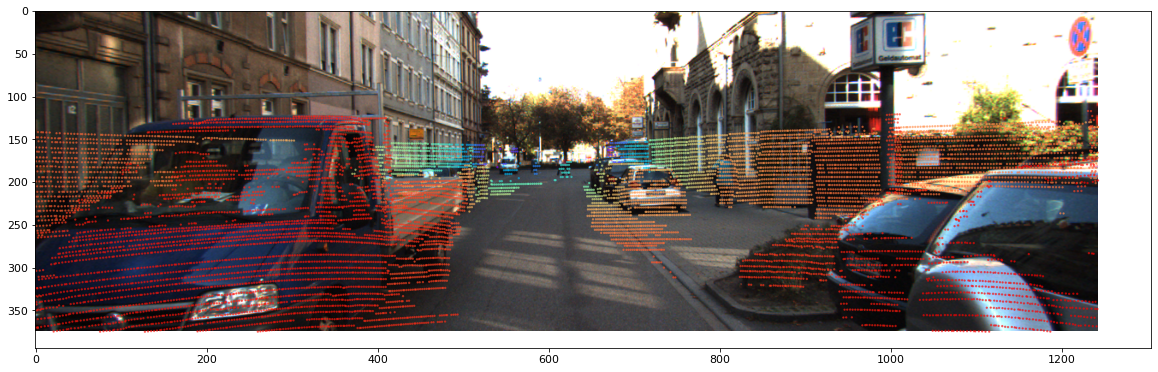

In [32]:
# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

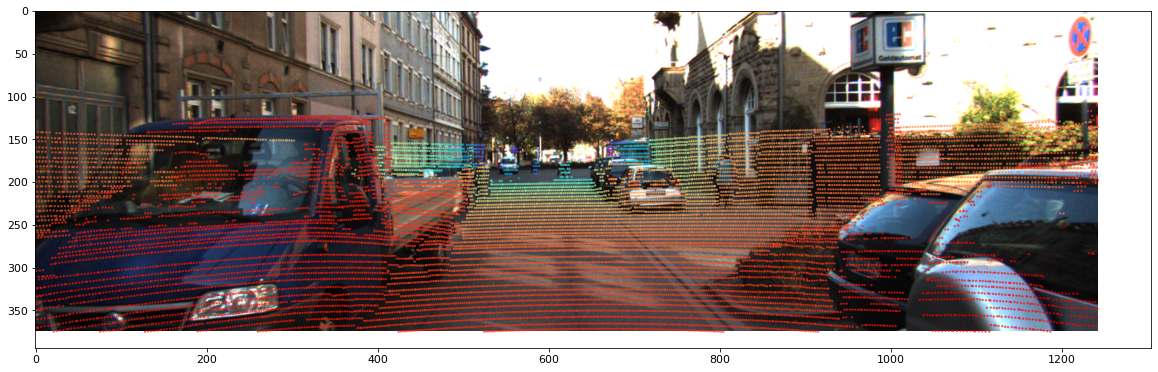

In [33]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=False)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Get Object Detection Pipeline**

Just like part 1, we will use yolov5

In [28]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12130, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 12130 (delta 45), reused 53 (delta 27), pack-reused 12047
Receiving objects: 100% (12130/12130), 12.59 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (8338/8338), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [30]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-31 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [34]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [35]:
def get_distances(image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int), 
                             np.round(x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return image, bboxes_out

In [36]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True, 
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    left_image, bboxes_out = get_distances(left_image, 
                                           velo_camera, 
                                           bboxes, 
                                           draw=draw_depth)

    return left_image, bboxes_out, velo_camera

## **Test the base pipeline**

In [37]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

left_image, bboxes_out, velo_camera = get_depth_detections(left_image, 
                                                           lidar_bin, 
                                                           draw_boxes=True, 
                                                           draw_depth=True)

In [38]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):
   
    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1, 
                  color_map(z[i]), -1);

    return velo_image


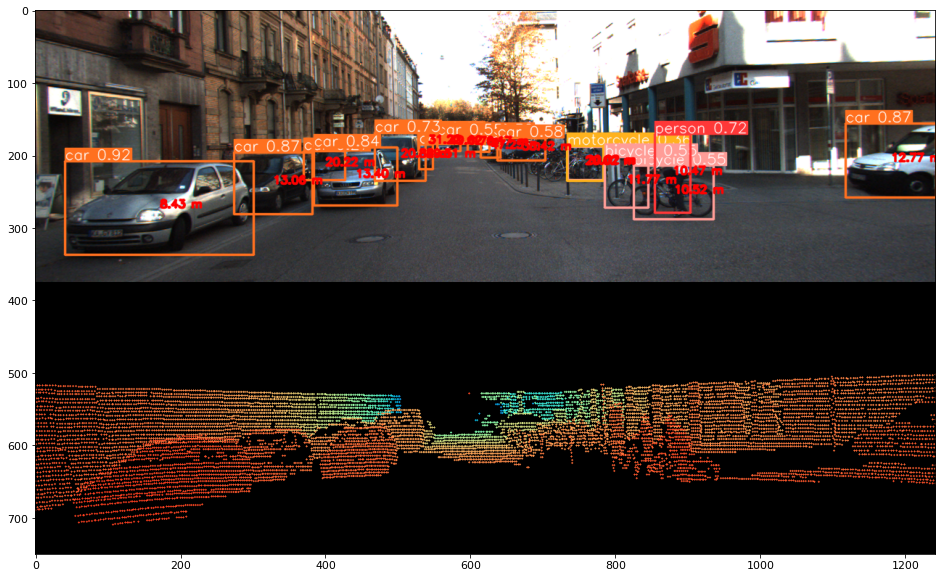

In [39]:
velo_image = np.zeros_like(left_image)
velo_image = draw_velo_on_image(velo_camera, velo_image)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [49]:
# get object centers and rotate them to LiDAR space
object_centers = np.hstack((bboxes_out[:, 6:], np.ones((len(bboxes_out), 1))))
object_centers 

array([[     273.22,      170.92,      8.4331,           1],
       [     204.98,      1180.8,      12.768,           1],
       [     235.58,      329.19,      13.057,           1],
       [     231.49,      442.15,      13.397,           1],
       [     203.47,      503.98,      20.855,           1],
       [     227.42,      877.66,      10.472,           1],
       [     194.93,      671.39,      33.416,           1],
       [     207.42,      573.49,      49.623,           1],
       [     238.17,      814.91,      11.769,           1],
       [     252.16,      882.25,      10.521,           1],
       [     193.53,      628.75,      47.248,           1],
       [     212.79,      758.63,       20.02,           1],
       [     181.27,      612.88,      76.168,           1],
       [     212.79,      758.63,       20.02,           1],
       [     205.41,       539.6,      29.514,           1],
       [     214.59,      400.11,      20.223,           1],
       [     192.83,    

In [51]:
R_left_rect

array([[    0.99988,    0.015115,  -0.0028416,           0],
       [  -0.015117,     0.99989, -0.00093385,           0],
       [  0.0028272,   0.0009767,           1,           0],
       [          0,           0,           0,           1]])

In [46]:
np.c_[object_centers[0, :]]

array([[     273.22],
       [     170.92],
       [     8.4331]])

In [52]:
np.linalg.inv(R_left_rect) @ np.c_[object_centers[0, :]]

array([[     270.62],
       [     175.04],
       [     7.4971],
       [          1]])

In [55]:
T_cam_velo

array([[  0.0075337,    -0.99997,  -0.0006166,  -0.0040698],
       [   0.014802,  0.00072807,    -0.99989,   -0.076316],
       [    0.99986,   0.0075238,    0.014808,    -0.27178],
       [          0,           0,           0,           1]])

In [56]:
np.linalg.inv(T_cam_velo) @ np.linalg.inv(R_left_rect) @ np.c_[object_centers[0, :]]

array([[     12.399],
       [    -270.43],
       [    -175.15],
       [          1]])

## **Lets move on to extracting 3D point cloud objects**

First we need to run the RANSAC algorithm to remove the plane. But we will need to use the points the LiDAR frame of reference, so we need a way of contiunously relating the image point cloud with the True LiDAR point cloud

Read points directly from bin file and use RANSAC to remove the ground plane

In [58]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

In [61]:
velo_points.max()

78.764

Now let's run K-means clustering in LiDAR space to get object clusters. First we will seed K-means with the centers of the detected objects

In [75]:
def image_clusters_from_velo(velo_points, labels, image):
    ''' Obtains clusters in image space from velo (LiDAR) points 
        Inputs:
            velo_points (4xN) Homogeneous LiDAR points
            labels (N,) cluster labels (clusters formed in LiDAR space)
            image - reference image for transformation from LiDAR to image space
        Outputs:
            clusters (list) list that contains each cluster label and cluster
        '''
    clusters = []
    for label in np.unique(labels):
        # convert from velo to camera 
        velo_cam = velo2camera(velo_points[:, labels == label], image)
        
        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            clusters.append([label, velo_cam])

    return clusters

In [76]:
def draw_clusters_on_image(image, clusters, draw_centroids=False):
    ''' draws the clusters on an image '''
    pastel = cm.get_cmap('Pastel2', lut=50)
    get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

    for cluster in clusters:
        label = cluster[0]
        for (u, v, z) in cluster[1].T:
            cv2.circle(image, (int(u), int(v)), 1, 
                       get_pastel(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster[1], axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5, 
                       get_pastel(label), -1);

    return image


Read LiDAR data directly from bin file

In [77]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

Use DBSCAN to cluster points

In [93]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(min_samples=30)

In [94]:
labels = dbscan.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [95]:
clusters = image_clusters_from_velo(velo_points, labels, left_image)

In [96]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, clusters, draw_centroids=True)

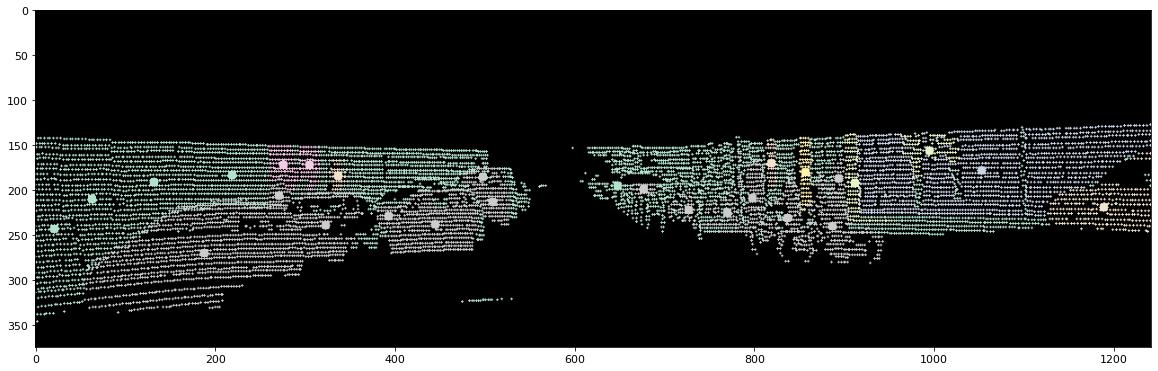

In [97]:
plt.imshow(new_image)

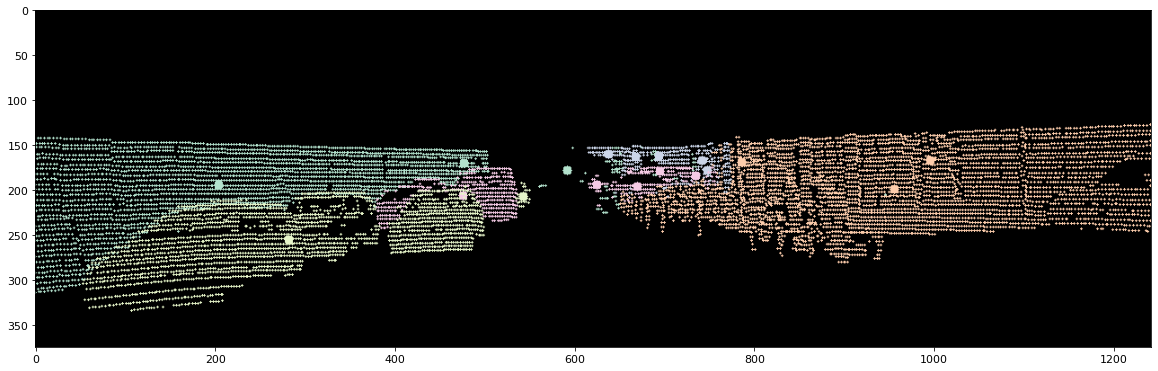

In [ ]:
plt.imshow(new_image)

## Now we have multiple clusters, now we need to associate clusters to each detected object

In [ ]:
object_centers = bboxes_out[:, 6:]
object_centers

In [136]:
np.array(clusters[1:])[:, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([0, 1, 2, 3, 18, 19, 20, 28, 29, 34, 39, 41, 42, 43, 45, 47, 48, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64], dtype=object)

In [145]:
centroid

array([     219.89,      183.41,      18.193])

In [523]:
# asscoiate cluster to each detected object by computing the closest centroid
matches = []
cost = []
for cluster in clusters[1:]:

    # print(cluster[1].shape)
    if cluster[1].shape[1] > 20: 
        centroid = np.mean(cluster[1], axis=1)
        centroid = np.hstack((centroid[1], centroid[0], centroid[2]))

        delta = np.linalg.norm(centroid - object_centers, axis=1)
        min_loc = np.argmin(delta)
        print(cluster[0], min_loc, delta[min_loc])
        # print(centroid)

        matches.append([cluster[0], min_loc, delta[min_loc]])
        cost.append(delta)

matches = np.array(matches)
cost = np.array(cost)

0 0 102.74795566726736
1 0 90.46778602010026
2 0 124.51888978409453
3 0 152.63675187533266
18 1 130.4866369501036
19 2 67.78647249428305
20 2 82.19280307779403
28 5 137.75031630301547
29 5 50.07775060895503
34 5 52.0838933251984
39 8 69.06500230305954
41 1 16.688235489432838
42 2 52.97170277848298
43 8 32.79498410816709
45 4 19.01864660113069
47 5 44.29692643778493
48 2 64.36724585355576
53 8 24.042562862727603
54 4 11.510378152538348
56 9 12.163185398297095
57 6 7.752884328194007
58 3 8.166811642712286
59 2 7.116419321223754
60 0 18.032889306375612
62 15 15.993973277825697
63 11 32.980315464970474
64 11 17.036123548669572


In [524]:
# suppress duplicate matches (use hungarian in the future?)
sup_matches = []
for m in np.unique(matches[:, 1]):
    min_loc = np.argmin(matches[matches[:, 1] == m, 2])

    sup_matches.append(matches[min_loc, :])

sup_matches = np.array(sup_matches)

In [525]:
# now display matched clusters

In [543]:
# let's take the easy way out, remove clusters with min/max values and continue

new_clusters = []
noise_cluster = clusters[0]
for cluster in clusters[1:]:

    # print(cluster[1].shape)
    if cluster[1].shape[1] > 20 and cluster[1].shape[1] < noise_cluster[1].shape[1] //2: 

        centroid = np.mean(cluster[1], axis=1)
        centroid = np.hstack((centroid[1], centroid[0], centroid[2]))

        delta = np.linalg.norm(centroid - object_centers, axis=1)
        min_loc = np.argmin(delta)
        print(delta[min_loc])
        if delta[min_loc] < 75:
            new_clusters.append(cluster)



102.74795566726736
90.46778602010026
124.51888978409453
152.63675187533266
67.78647249428305
82.19280307779403
137.75031630301547
50.07775060895503
52.0838933251984
69.06500230305954
16.688235489432838
52.97170277848298
32.79498410816709
19.01864660113069
44.29692643778493
64.36724585355576
24.042562862727603
11.510378152538348
12.163185398297095
7.752884328194007
8.166811642712286
7.116419321223754
18.032889306375612
15.993973277825697
32.980315464970474
17.036123548669572


In [544]:
len(clusters)

28

In [545]:
len(new_clusters)

20

In [546]:
cluster = new_clusters[10]
cluster[1].shape

(3, 162)

In [547]:
from sklearn.preprocessing import StandardScaler

scaled_cluster = StandardScaler().fit_transform(cluster[1].T)
scaled_cluster = cluster[1].copy().T

In [245]:
# now get principle axes for the clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(scaled_cluster)

PCA(n_components=3)

In [268]:
# get principle axes
pca_comp = pca.components_
pca_comp

array([[   -0.99767,     0.06767,   0.0085898],
       [   -0.06758,    -0.99766,    0.010419],
       [  0.0092747,   0.0098141,     0.99991]])

In [265]:
# get explained variance in each direction
pca_var = pca.explained_variance_
pca_var

array([     1022.6,      272.88,    0.038597])

In [267]:
pca_std = np.sqrt(pca_var)
pca_std

array([     31.978,      16.519,     0.19646])

In [269]:
new_image = np.zeros_like(left_image)
for (u,v,z) in cluster[1].T:
    cv2.circle(new_image, (int(u), int(v)), 1, [0, 255, 0], -1);

In [270]:
scaled_cluster_centroid = np.mean(scaled_cluster, axis=0)
scaled_cluster_centroid

array([     1189.8,      219.08,      12.726])

In [272]:
# plot max explained variance points
p_x = np.array([pca_var[0], scaled_cluster_centroid[1], scaled_cluster_centroid[2]])
p_y = np.array([scaled_cluster_centroid[0], pca_var[1], scaled_cluster_centroid[2]])

cv2.circle(new_image, p_x[:2].astype(int), 10, [255, 0, ], -1);
cv2.circle(new_image, p_y[:2].astype(int), 10, [255, 0, 0], -1);

In [273]:
p_x

array([     1022.6,      219.08,      12.726])

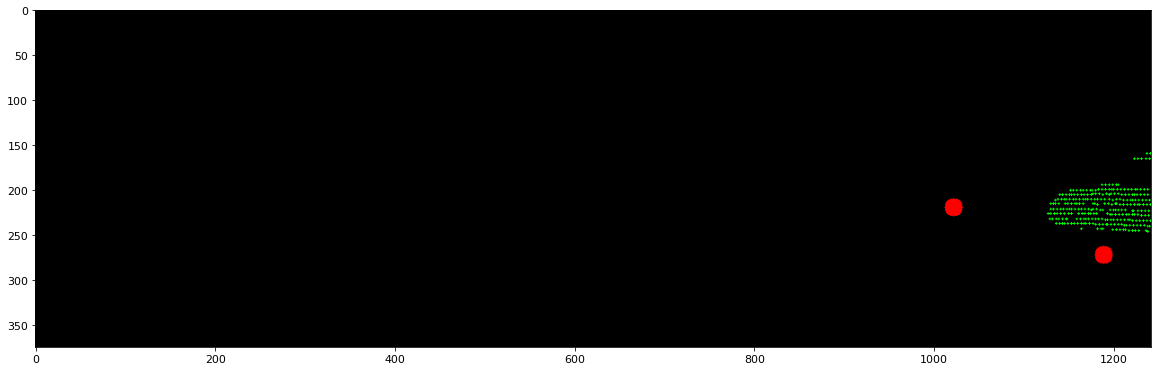

In [274]:
plt.imshow(new_image)

In [ ]:
# now just get u min/max, v min/max, z min/max and get a box using these coordinates

In [585]:
arr = np.ones((8, 3))

# there's a better way to do this
arr[::2, 2] *= -1
arr[4:, 0] *= -1
arr[2:4, 1] *= -1
arr[6:, 1] *= -1

camera_box_point_list = []

for label, cluster in new_clusters:
    print(label)

    velo_cluster = velo_points[:3, labels == label]


    (x_min, y_min, z_min) = velo_cluster.min(axis=1)
    (x_max, y_max, z_max) = velo_cluster.max(axis=1)

    cluster_centroid = np.mean(velo_cluster, axis=1)
    print(cluster_centroid)

    camera_cluster_centroid = T_velo_cam @ np.hstack((cluster_centroid, np.array([1]))).reshape((-1, 1))
    camera_cluster_centroid[:2] /= camera_cluster_centroid[2, :]
    print(camera_cluster_centroid)
    print()

    # now get points to define 3d bounding box
    # box_points = np.array([[x_max, y_max, z_max]]) * arr
    # just manually do this for now
    box_points = np.array([
        [x_max, y_max, z_max, 1],
        [x_max, y_max, z_min, 1],
        [x_max, y_min, z_max, 1],
        [x_max, y_min, z_min, 1],
        [x_min, y_max, z_max, 1],
        [x_min, y_max, z_min, 1],
        [x_min, y_min, z_max, 1],
        [x_min, y_min, z_min, 1]
    ])

    # convert these box points to image space
    camera_box_points = T_velo_cam @ box_points.T
    camera_box_points[:2] /= camera_box_points[2, :]

    # ensure all box points have a consistent value
    # use min/max values to ensure this

    # (cx_min, cy_min, cz_min) = camera_box_points.min(axis=1).round().astype(int)
    # (cx_max, cy_max, cz_max) = camera_box_points.max(axis=1).round().astype(int)

    # # once again do this explicitly for now
    # camera_box_points = np.array([
    #     [cx_max, cy_max, cz_max],
    #     [cx_max, cy_max, cz_min],
    #     [cx_max, cy_min, cz_max],
    #     [cx_max, cy_min, cz_min],
    #     [cx_min, cy_max, cz_max],
    #     [cx_min, cy_max, cz_min],
    #     [cx_min, cy_min, cz_max],
    #     [cx_min, cy_min, cz_min]
    # ])

    camera_box_points = camera_box_points.round().T.astype(int)

    # append to list
    camera_box_point_list.append(camera_box_points)

19
[     23.724      10.056     0.41189]
[[     305.99]
 [     172.77]
 [     23.505]]

29
[     16.549     -6.6776    -0.38236]
[[     912.51]
 [     191.86]
 [     16.242]]

34
[     19.807     -6.5466    -0.10815]
[[     857.43]
 [     180.27]
 [     19.504]]

39
[     22.983     -6.4488     0.22233]
[[      819.9]
 [     170.16]
 [     22.684]]

41
[     12.804     -11.454    -0.65669]
[[     1279.7]
 [     206.12]
 [     12.471]]

42
[     26.635      10.154   0.0078837]
[[     337.27]
 [     184.95]
 [     26.411]]

43
[     15.707     -3.8915    -0.71313]
[[      798.5]
 [      209.9]
 [     15.408]]

45
[     22.678      3.6191   -0.094836]
[[     498.53]
 [     185.33]
 [     22.423]]

47
[     21.854     -8.3306    -0.35562]
[[     894.23]
 [     187.86]
 [     21.539]]

48
[     18.338      8.6246    -0.53533]
[[     271.93]
 [     206.65]
 [       18.1]]

53
[     12.029     -3.5822    -0.91552]
[[     837.84]
 [     231.15]
 [     11.729]]

54
[     21.126       3.056    -

In [586]:
camera_box_points

array([[746, 198,  18],
       [747, 238,  18],
       [787, 197,  18],
       [788, 237,  18],
       [753, 199,  17],
       [754, 241,  17],
       [796, 198,  17],
       [797, 240,  17]])

In [587]:
camera_box_points.max(axis=1)

array([746, 747, 787, 788, 753, 754, 796, 797])

In [588]:
box_pts.T.round()

array([[797, 797, 797, 797, 746, 746, 746, 746],
       [241, 241, 197, 197, 241, 241, 197, 197],
       [ 18,  17,  18,  17,  18,  17,  18,  17]])

In [589]:
pastel = cm.get_cmap('Pastel2', lut=50)
get_pastel = lambda z : [255*val for val in pastel(z)[:3]]

for i, box_pts in enumerate(camera_box_point_list):
    for pts in box_pts:
        u = pts[0]
        v = pts[1]
        cv2.circle(new_image, (int(u), int(v)), 10, 
                          get_pastel(i), -1);

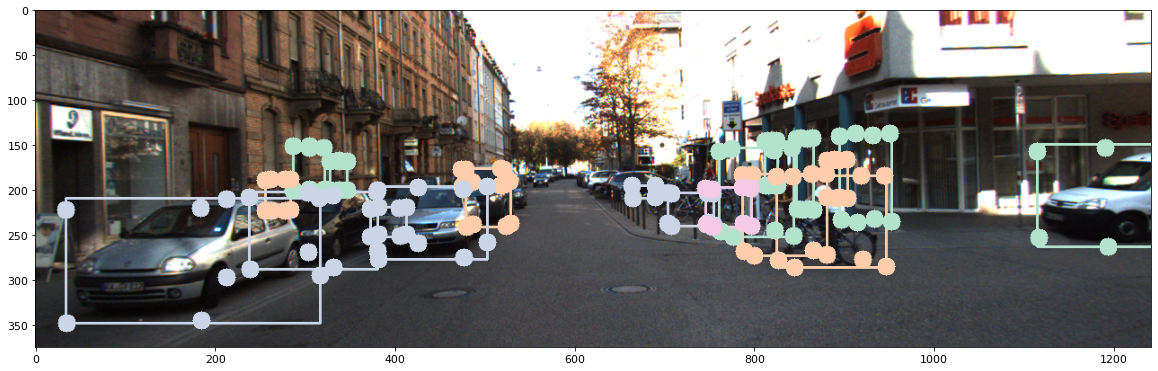

In [590]:
plt.imshow(new_image)

In [591]:
# draw 3d bounding boxes
new_image = np.zeros_like(left_image)

In [592]:
camera_box_point_list[-1][:, :2]

array([[746, 198],
       [747, 238],
       [787, 197],
       [788, 237],
       [753, 199],
       [754, 241],
       [796, 198],
       [797, 240]])

In [593]:
[A, B, C, D, E, F, G, H] = camera_box_point_list[-1][:, :2]

In [594]:
camera_box_point_list[-1][:, :2]

array([[746, 198],
       [747, 238],
       [787, 197],
       [788, 237],
       [753, 199],
       [754, 241],
       [796, 198],
       [797, 240]])

In [595]:
cv2.rectangle(new_image, A, D, [0, 255, 0], 2);
cv2.rectangle(new_image, E, B, [0, 255, 0], 2);
cv2.rectangle(new_image, E, H, [0, 255, 0], 2);
cv2.rectangle(new_image, G, D, [0, 255, 0], 2);

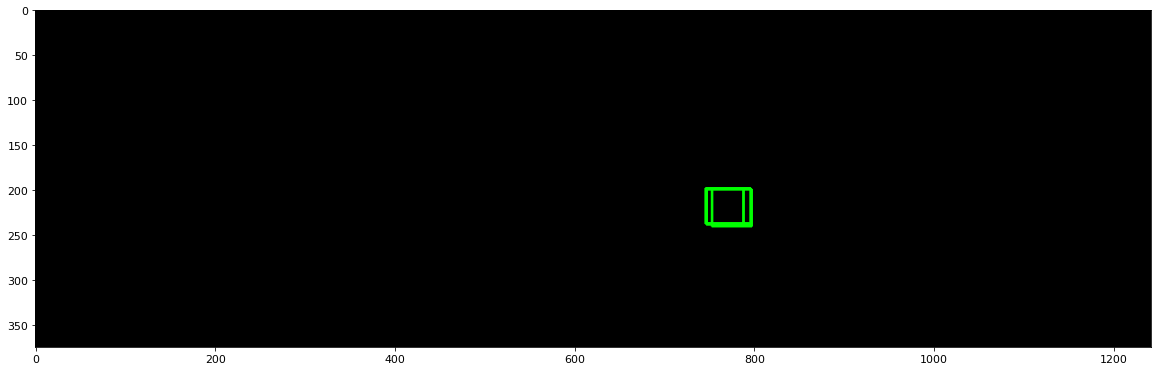

In [596]:
plt.imshow(new_image)

In [597]:
new_image = np.zeros_like(left_image)
new_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)

for i, box_pts in enumerate(camera_box_point_list):
    if i > -1:
        [A, B, C, D, E, F, G, H] = box_pts[:, :2]
        color = get_pastel(i)
        # cv2.rectangle(new_image, A, D, color, 2);
        # cv2.rectangle(new_image, E, B, color, 2);
        # cv2.rectangle(new_image, E, H, color, 2);
        # cv2.rectangle(new_image, G, D, color, 2);

        cv2.rectangle(new_image, A, D, color, 2);
        cv2.rectangle(new_image, E, H, color, 2);
        cv2.rectangle(new_image, E, C, color, 2);
        cv2.rectangle(new_image, F, D, color, 2);

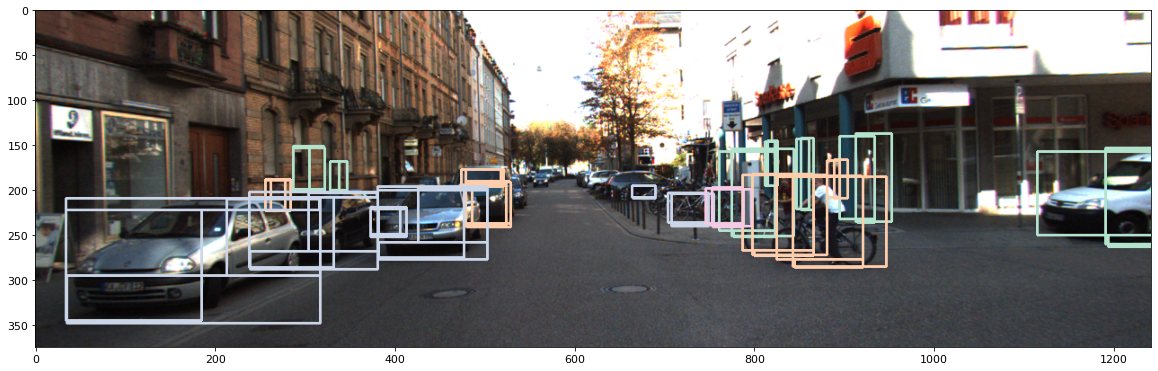

In [598]:
plt.imshow(new_image);

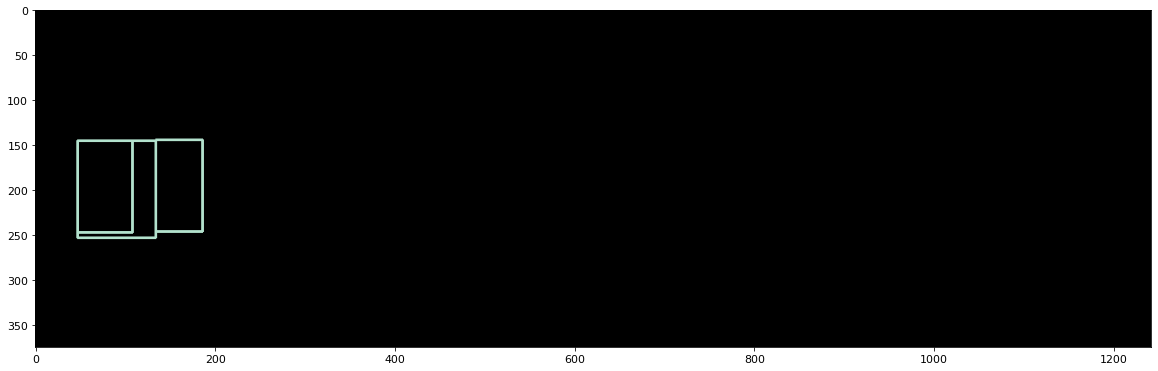

In [471]:
plt.imshow(new_image);

Convert camera reference to real world units
https://stackoverflow.com/questions/47054848/converting-pixel-width-to-real-world-width-in-millimeters-using-camera-calibrati

Camera calibration info
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-for-camera-calibration-in-computer-vision/

Sensor size of cameras used
https://www.alliedvision.com/en/camera-selector/detail/manta/g-146/

compute camera sensor width: http://www.lightcrafttech.com/support/doc/lens-interface/camera-sensor/

TO get the width of the sensor in pixels we divide the physical width of the sensor (in meters) by the nuber of pixels along the horizonal axis

calculate pixel pitch: https://myelo.elotouch.com/support/s/article/How-to-Calculate-Pixel-Pitch

https://www.fdxlabs.com/calculate-x-y-z-real-world-coordinates-from-a-single-camera-using-opencv/

In [ ]:
focal_length = K_left[0, 0]

In [ ]:
sensor_width_pix = 1382

In [ ]:
!pip install open3d

In [ ]:
masked_velo_points[:3, :]

array([[     76.942,      75.186,      73.536, ...,      14.955,      15.038,      15.174],
       [     11.739,      11.712,      11.691, ...,      -2.981,      -2.973,      -2.951],
       [      2.841,       2.782,       2.727, ...,      -6.995,      -7.032,      -7.092]], dtype=float32)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()

xyz = np.asarray(masked_velo_points[:3, :].T)
pcd.points = o3d.utility.Vector3dVector(xyz)

In [ ]:
# cluster point cloud
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=20, 
                                         min_points=8, 
                                         print_progress=True))

In [ ]:
np.unique(labels)

NameError: ignored

In [ ]:
import copy

pcd2 = copy.deepcopy(pcd)

max_label = labels.max() + 1
colors = plt.get_cmap('tab20')(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd2.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [ ]:
pcd2

PointCloud with 10310 points.

In [ ]:
def get_clusters_from_labels(pcd, labels, include_outliers=True):
    ''' Obtains a list of individual cluster point clouds and paints them 
        unique colors. Assumes that the pcd object has a uniform color.
        Inputs:
            pcd - open3d PointCloud object
            labels - (Nx1 array) labels for each point in the cluster
            include_outliers - (_Bool) determines whether outlaiers should be 
                               included in the output list
        Outputs:
            unique_labels (list) Contains all labels for each cluster
            clusters (list) Contains PointCloud objects for each color
        '''
    # get colors 
    max_label = labels.max()
    colors = plt.get_cmap('tab20')
    colors = colors(labels/(max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    
    unique_labels = np.sort(np.unique(labels))
    
    # remove -1 (unclustered label) to remove outliers if desired
    if not include_outliers:
        unique_labels = unique_labels[unique_labels != -1]

    # store cluster point clouds in a list
    clusters = []
    
    # iterate through each unique label
    for label in unique_labels:
        # get index of points and colors
        cluster_idx = np.where(label == labels)[0]
        
        # get cluster color
        color = colors[cluster_idx, :3]
        
        # get cluster points
        cluster = pcd.select_by_index(cluster_idx)
        
        # paint cluster
        cluster.colors = o3d.utility.Vector3dVector(color)
        
        # append to list
        clusters.append(cluster)
    
    return unique_labels, clusters

consider the first object with bbox_out of:
[     41.952,      208.31,      301.98,      337.09,       0.923,           2,      273.22,      170.92,      8.4331]


In [ ]:
u_locs = (masked_velo_camera[0, :] >= 40) & (masked_velo_camera[0, :] <= 310)
v_locs = (masked_velo_camera[1, :] >= 200) & (masked_velo_camera[1, :] <= 340)

In [ ]:
obj1_velo_camera = masked_velo_camera[:, u_locs & v_locs]
obj1_velo_camera.shape

(3, 1960)

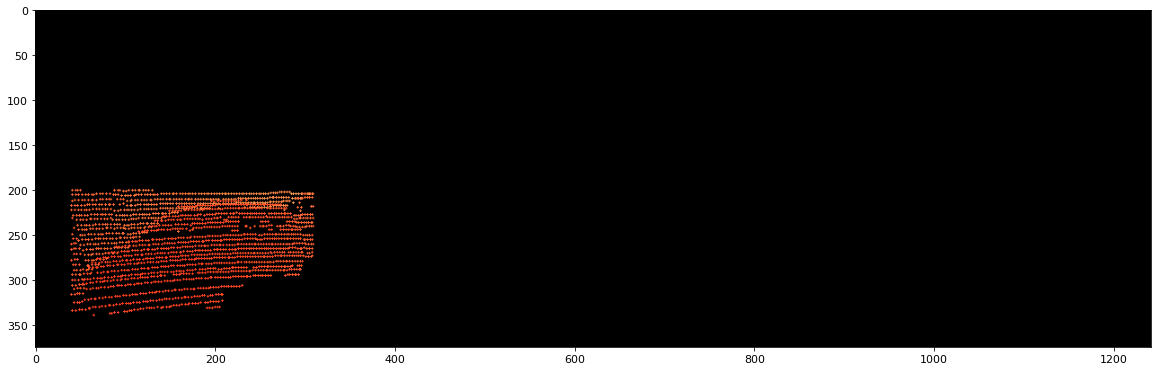

In [ ]:
new_image = np.zeros_like(left_image)
new_image = draw_velo_on_image(obj1_velo_camera, new_image)

plt.imshow(new_image);

In [ ]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=5, min_samples=5)

model.fit(obj1_velo_camera.T)

DBSCAN(eps=5)

In [ ]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [ ]:
velo_camera.T.max(axis=0)

array([     1241.9,      374.99,      78.473])

In [ ]:
np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T

array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]])

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=17, init=np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T)
# model.init(bboxes_out[:, 6:8])
model.fit(velo_camera.T)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]]),
       n_clusters=17)

In [ ]:
np.unique(model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [ ]:
# p#astel = cm.get_cmap('hsv')
# get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera # obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    if labels[i] == 15:
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_pastel(labels[i]), -1);

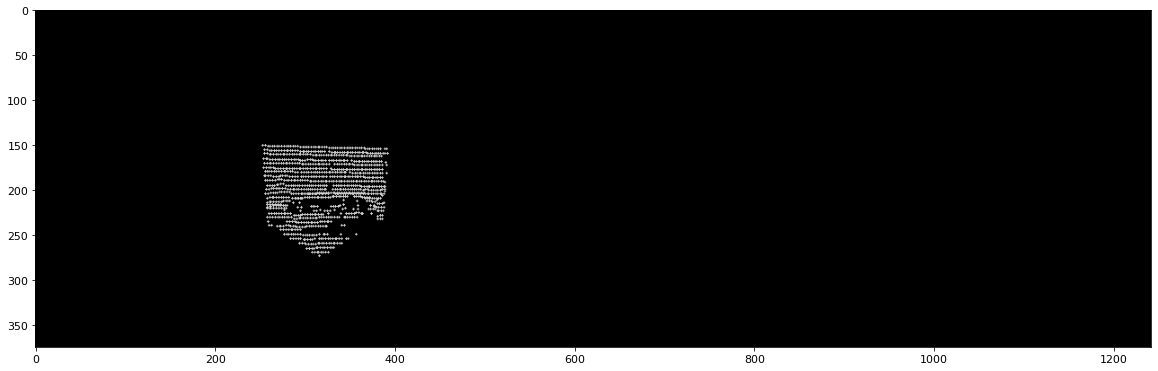

In [ ]:
plt.imshow(new_image);

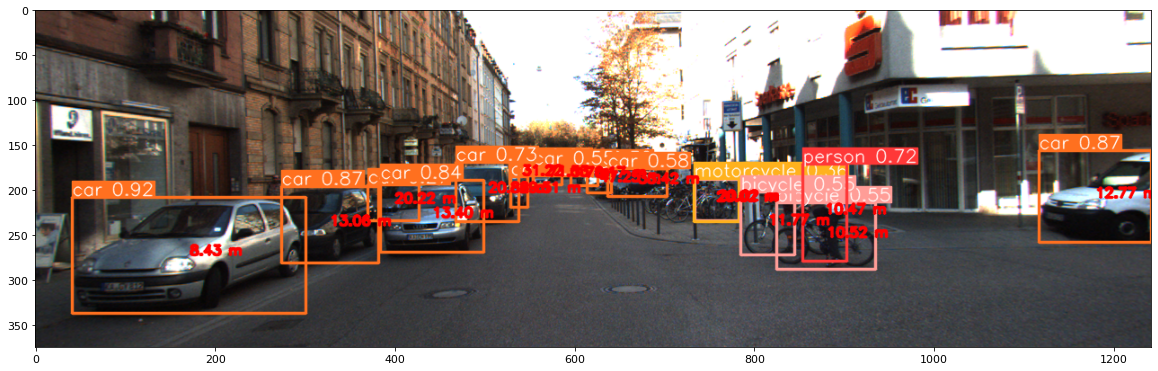

In [ ]:
plt.imshow(left_image)

In [ ]:
obj1_velo_camera[1, :].shape

(2217,)

In [ ]:
pastel = cm.get_cmap('hsv')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_pastel(labels[i]), -1);

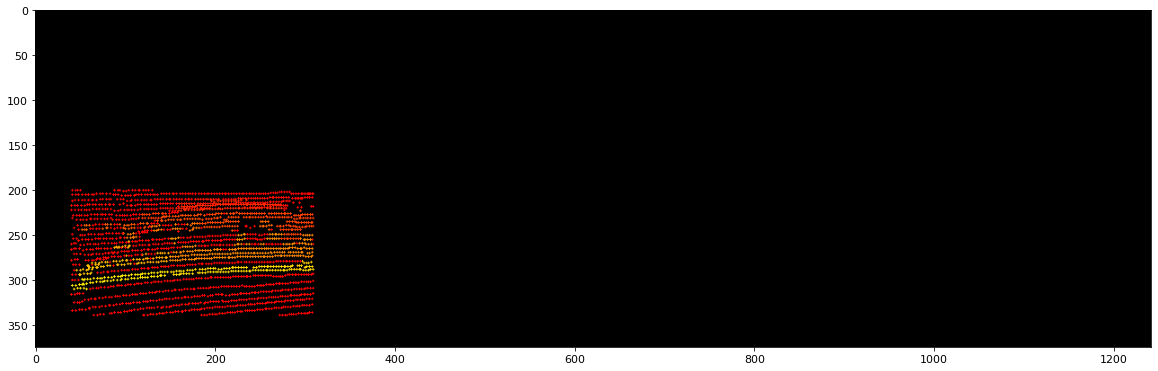

In [ ]:
plt.imshow(new_image);

## Now we can try to use PCA to get principle axes of the object of interest

## **Now make a full pipeline**
This pipeline will input a stereo pair along with a LiDAR point cloud. It will compute stereo depth and log error info

## **Now let's run the depth check on another sample of KITTI data!**

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 18:56:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  10.8MB/s    in 4m 36s  

2022-08-28 19:00:50 (10.7 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 19:00:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 19:00:52 (58.0 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [ ]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [ ]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [ ]:
error_metrics = []
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # draw LiDAR point cloud on new blank image
    u, v, z = velo_camera
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    for i in range(len(u)):
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

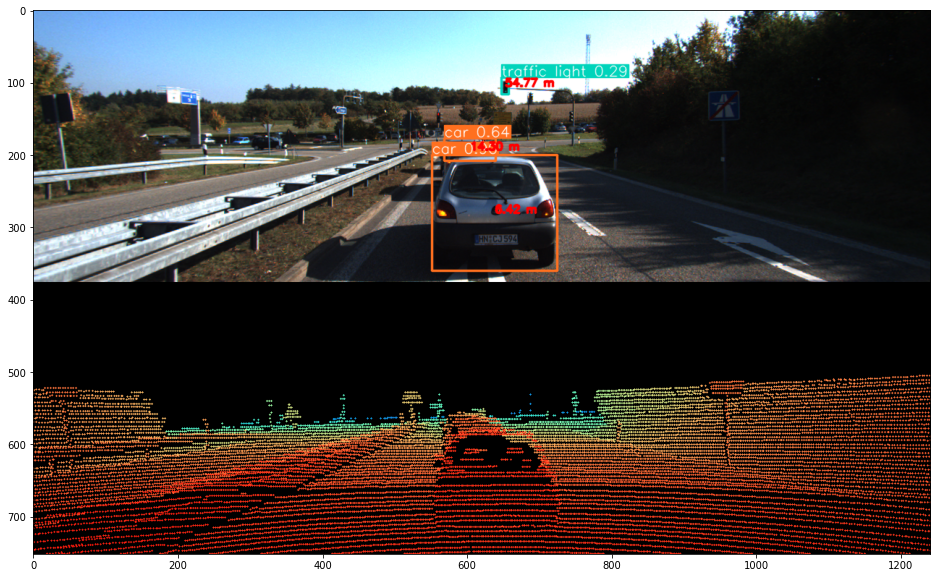

In [ ]:
plt.imshow(stacked);